In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from collections import Counter
from seaborn import heatmap
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import re
from scipy import spatial

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from spacy.tokens import Doc, Token, Span

import gensim
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import linear_kernel

In [3]:
import random

In [70]:
nlp=spacy.load('en_core_web_md')

In [15]:
df=pd.read_csv('final_stories_no_vectors.csv')

# Preprocessing the Entire Dataset

In [16]:
def check_stop_punct(token):
    if token.is_stop or token.is_punct:
        return False
    else:
        return True

def clean_doc_lem_stop(document):
    no_stop_li = list(filter(check_stop_punct, document))
    lemma_li = list(map(lambda x: x.lemma_, no_stop_li))
    spaces=[True for word in lemma_li]
    doc=Doc(nlp.vocab, words=lemma_li, spaces=spaces)
    return doc

In [17]:
nlp.add_pipe(clean_doc_lem_stop, first=True)
nlp.pipe_names

['clean_doc_lem_stop', 'tagger', 'parser', 'ner']

In [18]:
docs=list(nlp.pipe(df.story_text, batch_size=100, cleanup=True, n_process=-1))

In [19]:
df['vectors']=[x.vector for x in docs]

In [23]:
#L2 normalized vectors test
vec1= docs[0].vector_norm
vec2= docs[0].vector_norm
1-spatial.distance.cosine(vec1, vec2)

1.0

In [ ]:
docs[i].similarity(other)

In [96]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

array([[ 1.6161983e-04, -1.7077739e-03,  1.9612685e-03, ...,
        -1.8608831e-04,  8.5919120e-05, -1.3444798e-04],
       [-1.7077739e-03,  1.8045383e-02, -2.0723961e-02, ...,
         1.9663228e-03, -9.0787397e-04,  1.4206596e-03],
       [ 1.9612685e-03, -2.0723961e-02,  2.3800137e-02, ...,
        -2.2581953e-03,  1.0426348e-03, -1.6315361e-03],
       ...,
       [-1.8608831e-04,  1.9663228e-03, -2.2581953e-03, ...,
         2.1426121e-04, -9.8926874e-05,  1.5480278e-04],
       [ 8.5919120e-05, -9.0787397e-04,  1.0426348e-03, ...,
        -9.8926874e-05,  4.5675679e-05, -7.1474227e-05],
       [-1.3444798e-04,  1.4206596e-03, -1.6315361e-03, ...,
         1.5480278e-04, -7.1474227e-05,  1.1184432e-04]], dtype=float32)

In [138]:
df.loc[0,'story_text']

'I must ask you to go back more than two hundred years, and watch two people in a quiet old English garden. One is an old lady reading. In her young days she was a famous beauty. That was very long ago, to be sure; but I think she is a beauty still--do not you? She has such a lovely face, and her eyes are so sweet and bright! and better than that, they are the kind which see pleasant things in everybody, and something to like and be interested in. I hope with all my heart yours are that kind, too. The other person is a little child. She was christened Mary Brenton, like her grandmother; but she was called Polly all her days, for short; and we will call her so. She is sitting on the grass with a little cat in her arms, which she is trying to put to sleep. But the kitten is not so accommodating as a doll would be, and just as Polly does not dare to move for fear of waking her, she makes up her mind that a run after a leaf and a play with any chance caterpillar which may be so unlucky as 

#### Comparing performance spatial.distance.cosine to doc.similarity(otherdoc)

In [146]:
docs[0].similarity(docs[0])

1.0

Full dataset was too large to implement this dictionary function from the smaller model. Cosine similarity was used directly, without spaCy's doc functions

In [ ]:
#### 
'''
similarity_dict={}
for i in range(len(docs)):
    similarity_dict[i]=[docs[i].similarity(other) for other in docs]

In [30]:

vec1=df.loc[0,'vectors']
vec2=df.loc[0,'vectors']
1-spatial.distance.cosine(vec1, vec2)

1.0

In [149]:
df.to_csv('storieswithvectors.csv')

In [219]:
nlp.to_disk('spacymodel')


## Functions for the Recommendation Engine

Here, after preprocessing the entire dataset through spaCy, I designed, tested, and verified functions later used for the webapp.

In [ ]:
def similarity(vec1, vec2):
    return 1-spatial.distance.cosine(vec1, vec2)

In [227]:
def query(user_input, n=36):
    doc=nlp(user_input)
    input_vector=doc.vector
    unsorted_sim=[(i, df.loc[i,'story_title'], similarity(doc.vector, df.loc[i, 'vectors'])) for i in df.index if df.loc[i, 'word_count']>100]
    results=sorted(unsorted_sim, key=lambda x: x[2], reverse=True)
    return results

In [251]:
def find_similar_stories(story_id):
    story_vector=df.loc[story_id, 'vectors']
    unsorted_sim=[(i, df.loc[i,'story_title'], similarity(story_vector, df.loc[i, 'vectors'])) for i in df.index if df.loc[i, 'word_count']>100]
    results=sorted(unsorted_sim, key=lambda x: x[2], reverse=True)
    return results

In [253]:
def give_story_data(story_id):
    story_dict={}
    story_dict['title']=df.loc[story_id, 'story_title']
    story_dict['book']=df.loc[story_id, 'book_title']
    story_dict['author']=df.loc[story_id, 'book_author']
    for key, value in story_dict.items():
        if value=='frozenset()':
            story_dict[key]='Unknown'
    message=f"{story_dict['title']} \nFrom {story_dict['book']} \nBy {story_dict['author']}\n"
    return message

In [249]:
def present_n_options(story_id, n=9):
    all_results=find_similar_stories(story_id)[:3*n]
    strong_options= [result[0] for result in all_results[:n]]
    medium_options=[result[0] for result in all_results[n:2*n]]
    weak_options=[result[0] for result in all_results[2*n:3*n]]
    
    row_1_ids= [strong_options[random.randint(0,n-1)], weak_options[random.randint(0,n-1)], medium_options[random.randint(0,n-1)]]
    
    row_2_ids= [strong_options[random.randint(0,n-1)], weak_options[random.randint(0,n-1)], medium_options[random.randint(0,n-1)]]
    
    row_3_ids=[strong_options[random.randint(0,n-1)], weak_options[random.randint(0,n-1)], medium_options[random.randint(0,n-1)]]
    
    rows=[row_1_ids, row_2_ids, row_3_ids]
    for row in rows:
        for id in row:
            print(give_story_data(id))
            print('\n')



In [11]:
#Final draft of functions
def similarity(vec1, vec2):
    return 1-spatial.distance.cosine(vec1, vec2)
    
def query(user_input):
    doc=nlp(user_input)
    input_vector=doc.vector
    unsorted_sim=[(i, similarity(doc.vector, df.loc[i, 'vectors'])) for i in df.index if df.loc[i, 'word_count']>120]
    results=sorted(unsorted_sim, key=lambda x: x[1], reverse=True)
    return results

def find_similar_stories(story_id):
    story_vector=df.loc[story_id, 'vectors']
    unsorted_sim=[(i, similarity(story_vector, df.loc[i, 'vectors'])) for i in df.index if df.loc[i, 'word_count']>100]
    results=sorted(unsorted_sim, key=lambda x: x[2], reverse=True)
    return results

def give_story_data(story_id):
    story_dict={}
    story_dict['title']=df.loc[story_id, 'story_title']
    story_dict['book']=df.loc[story_id, 'book_title']
    story_dict['author']=df.loc[story_id, 'book_author']
    for key, value in story_dict.items():
        if value=='frozenset()':
            story_dict[key]='Unknown'
    message=f"{story_dict['title']} \nFrom {story_dict['book']} \nBy {story_dict['author']}\n"
    return message

def present_n_options(story_id, n=9):
    all_results=find_similar_stories(story_id)[:3*n]
    strong_options= [result[0] for result in all_results[:n]]
    medium_options=[result[0] for result in all_results[n:2*n]]
    weak_options=[result[0] for result in all_results[2*n:3*n]]
    
    row_1_ids= [strong_options[random.randint(0,n-1)], weak_options[random.randint(0,n-1)], medium_options[random.randint(0,n-1)]]
    
    row_2_ids= [strong_options[random.randint(0,n-1)], weak_options[random.randint(0,n-1)], medium_options[random.randint(0,n-1)]]
    
    row_3_ids=[strong_options[random.randint(0,n-1)], weak_options[random.randint(0,n-1)], medium_options[random.randint(0,n-1)]]
    
    rows=[row_1_ids, row_2_ids, row_3_ids]
    for row in rows:
        for id in row:
            print(give_story_data(id))
            print('\n')

To make the results more diverse while keeping the results list concise,  I created a randomization function to pull from strong, weak, and medium choices.

In [278]:
def sample_results(results, n=12):
    strong_options=results[:n]
    medium_options=results[n:2*n]
    weak_options=results[2*n:3*n]
    
    sampled_items=[]
    for index in range(n//3):
        new_group= [strong_options[random.randint(0,n-1)], weak_options[random.randint(0,n-1)], medium_options[random.randint(0,n-1)]]
        sampled_items+=new_group
    return sampled_items


In [280]:
sample_results(query('A grasshopper begs ants for food after summer.'))

[(12935, 'The Delicate Heron', 0.8136813044548035),
 (1016, 'Red Squirrel And Bunny Cottontail', 0.8020840287208557),
 (1024, 'Insects And Worms', 0.8089824914932251),
 (2428, "Aunt Patty'S Pets", 0.8266382813453674),
 (1016, 'Red Squirrel And Bunny Cottontail', 0.8020840287208557),
 (6473, "The Animals' Christmas Tree", 0.8053054809570312),
 (14285, 'The Ants And The Grasshoppers', 0.8319112062454224),
 (272, 'September', 0.8006879687309265),
 (1024, 'Insects And Worms', 0.8089824914932251),
 (19327, 'Why The Stork Loves Holland', 0.8131182193756104),
 (19187, 'A Tail', 0.801068902015686),
 (6473, "The Animals' Christmas Tree", 0.8053054809570312)]

## Slice Text function to make stories more readable on the webapp

When users would go to read the text, it would be one solid block. Because line breaks (\n) were initially removed in order to perform TF-IDF and NLP, I had to figure out a way to break up the text in meaningful chunks. 

In [114]:
def slice_text(story_text):
    period_counter=0
    slices=[]
    
    n=0
    
    for i in range(len(story_text[n:])):
        '''
        if story_text[i] == '"':
            period_counter=0
            slices.append(story_text[n:i])
            n=i
            for j in range(len(story_text[n+1:])):
                if story_text[j]=='"':
                    if story_text[j-1]=='.':
                        slices.append(story_text[n:j+2])
                        n=j+2
                    else:
                        end=story_text[j+1:].index('.')
                        slices.append(story_text[n:end+2])
                        n=end+3
                        break
        '''                
        if story_text[i]=='!':
            period_counter=0
            slices.append(story_text[n:i+1])
            n=i+2
        
        elif story_text[i]=='.':
            period_counter+=1
            if period_counter>random.randint(3,6):
                slices.append(story_text[n:i+1])
                n=i+2
                period_counter=0
                
        elif i==len(story_text[n:])-1:
            slices.append(story_text[n:])
            n=i
        

    return slices
            

In [198]:
def slice_text(story_text):
    period_counter=0
    slices=[]
    n=0
    for i in range(len(story_text[n:])):

        if story_text[i]=='.' or story_text[i]=='!':
            period_counter+=1
            if period_counter==5:
                slices.append(story_text[n:i+2])
                n=i+1
                period_counter=0

        elif i==len(story_text):
            slices.append(story_text[n:i+1])

    return slices

In [199]:
for slice in slice_text(df.loc[69, 'story_text']):
    print(slice)

It seems absurd to say so, and at first sight almost impossible, that that one little word of only two letters could have so much power, and yet there is no doubt that the constant use of "if" spoilt Bessie Green's holiday and took away from it all the enjoyment and pleasure which she imagined a long summer day spent in the country would give. How she had thought about it and looked forward to it for weeks beforehand! Her parents were poor, hardworking people who rarely left home, and so the very idea of a treat like this was delightful, and she scarcely slept the night before, so afraid was she of not being ready in time. I cannot tell you how often she got up in the course of the night, either to see what o'clock it was or to look out of the window and wonder whether it was going to be a fine or a wet day, but it seemed to her as if morning would never come. However, long before six she was up and dressed, and with one last good-bye to her mother through the kitchen door was off to t

In [80]:
quote_split=df.loc[1024, 'story_text'].split('"')

for i in range(len(quote_split)):
    
    elif i%2 !=0:
        quote_split[i]='"'+quote_split[i]+'"'



["Long before two o'clock that afternoon the birds returned to their place in front of Father Thrift's cave. Some of them sat on the ground, some on the low branches of the trees, and others in the bushes. Now and again Shaggy Bear came out to tell some bird that Father Thrift wished to speak with him. Evidently important things were going on within the cave. But what? Oh, how the time dragged to those waiting birds! Would two o'clock never come? At last the cave door opened again, and Shaggy Bear came out with his prisoners. Shaggy was the sheriff, and his business was to take care that the boys did not run away. Hardly were they seated when Father Thrift came out of the cave. In one hand he carried a roll of paper, and with the other he adjusted the spectacles on his nose. He looked just like the judge he was supposed to be. As in a regular courtroom, every one straightened up and was all attention when the judge came. The queer little old man seated himself on the stump of a tree. B

In [252]:
def slice_text(story_text):
    period_counter=0
    slices=[]
    abbrev=['Mr','rs','Dr']
    n=0
    for i in range(len(story_text[n:])):

        if story_text[i]=='.' or story_text[i]=='!':
            if story_text[i-2:i] in abbrev:
                continue
            else:
                period_counter+=1
                if period_counter==5:
                    slices.append(story_text[n:i+2])
                    n=i+1
                    period_counter=0

        elif i==len(story_text)-2:
            new=story_text[n:-1]
            if new not in slices[-2:]:
                slices.append(new)
            break

    return slices

In [253]:
slice_text(df.loc[11650,'story_text'])


['Under none of the accredited ghostly circumstances, and environed by none of the conventional ghostly surroundings, did I first make acquaintance with the house which is the subject of this Christmas piece. I saw it in the daylight, with the sun upon it. There was no wind, no rain, no lightning, no thunder, no awful or unwonted circumstance, of any kind, to heighten its effect. More than that: I had come to it direct from a railway station: it was not more than a mile distant from the railway station; and, as I stood outside the house, looking back upon the way I had come, I could see the goods train running smoothly along the embankment in the valley. I will not say that everything was utterly commonplace, because I doubt if anything can be that, except to utterly commonplace people--and there my vanity steps in; but, I will take it on myself to say that anybody might see the house as I saw it, any fine autumn morning. ',
 " The manner of my lighting on it was this. I was travelling

In [202]:
small_df=df[['story_title', 'story_text', 'book_id', 'book_author', 'book_title', 'word_count']]

In [203]:
small_df

,story_title,story_text,book_id,book_author,book_title,word_count
0,The Orchard'S Grandmother,I must ask you to go back more than two hundre...,30720,Various,Happy Days for Boys and Girls,4438
1,Rough,"He was a donkey, and we called him Rough. He b...",30720,Various,Happy Days for Boys and Girls,1975
2,The Music Lesson,"Touch the keys lightly, Nellie, my dear: ...",30720,Various,Happy Days for Boys and Girls,77
3,The Frost,"The frost looked forth one still clear night, ...",30720,Various,Happy Days for Boys and Girls,343
4,My Picture,I have a little picture; Perchance you have...,30720,Various,Happy Days for Boys and Girls,260
...,...,...,...,...,...,...
21458,Mortuary Customs,"1240. If ""salt water pigeons'"" feathers are in...",18992,frozenset(),Current Superstitions\nCollected from the Oral...,1170
21459,Bodily Affections,"1340. If the right cheek burns, some one is sp...",18992,frozenset(),Current Superstitions\nCollected from the Oral...,943
21460,Apparel,1376. If you mend your apron or dress while on...,18992,frozenset(),Current Superstitions\nCollected from the Oral...,867
21461,The Moon,"All cereals, when planted in the waxing of the...",18992,frozenset(),Current Superstitions\nCollected from the Oral...,2199


In [204]:
small_df.to_csv('final_stories_no_vectors.csv')

### Test Object

I'm currently toying with the idea of using a result class in the future as it may result in faster run time. Currently each result is a dictionary object.

In [267]:
class Result:
    def __init__(self, id, similarity=None):
        self.id = id
        self.title=df.loc[self.id, 'story_title']
        self.story=df.loc[self.id, 'story_text']
        self.book=df.loc[self.id, 'book_title']
        self.author=df.loc[self.id, 'book_author']
        self.similarity=

In [268]:
orchard=Result(0)

In [272]:
print(orchard.title, orchard.book, orchard.author)

The Orchard'S Grandmother Happy Days for Boys and Girls Various


## Comparing L2_norm to Full Vectors

First attempt at deploying the web app was slow due to the large files. An attempt was made to lower the RAM necessary to run the application by using L2 norm/Euclidean Distance as opposed to Cosine Similarity. L2-normalization did not provide good results.

In [24]:
df['l2_norm']=[x.vector_norm for x in docs]

In [26]:
###Original Vectors
def similarity(vec1, vec2):
    return 1-spatial.distance.cosine(vec1, vec2)
    
def query(user_input):
    doc=nlp(user_input)
    input_vector=doc.vector
    unsorted_sim=[(i, similarity(doc.vector, df.loc[i, 'vectors'])) for i in df.index if df.loc[i, 'word_count']>120]
    results=sorted(unsorted_sim, key=lambda x: x[1], reverse=True)
    return results


In [30]:
### Test with L2
def l2_similarity(vec1, vec2):
    return 1-linearkernel(vec1, vec2)
    
def l2_query(user_input):
    doc=nlp(user_input)
    input_vector=doc.vector_norm
    unsorted_sim=[(i, l2_similarity(doc.vector, df.loc[i, 'l2_norm'])) for i in df.index if df.loc[i, 'word_count']>120]
    results=sorted(unsorted_sim, key=lambda x: x[1], reverse=True)
    return results

In [31]:
l2_query('A grasshopper begs ants for food after summer.')[:10]

[(0, 1.0295482920778953),
 (1, 1.0295482920778953),
 (3, 1.0295482920778953),
 (4, 1.0295482920778953),
 (5, 1.0295482920778953),
 (6, 1.0295482920778953),
 (7, 1.0295482920778953),
 (8, 1.0295482920778953),
 (10, 1.0295482920778953),
 (12, 1.0295482920778953)]

In [29]:
query('A grasshopper begs ants for food after summer.')[:10]

[(10841, 0.8651229739189148),
 (12623, 0.8322162628173828),
 (14285, 0.8319112062454224),
 (2428, 0.8266382813453674),
 (18885, 0.825995147228241),
 (12458, 0.8183417916297913),
 (1019, 0.8155062198638916),
 (19850, 0.8154550790786743),
 (19327, 0.8131182193756104),
 (2955, 0.812344491481781)]

### Exporting Finalized Word Vectors

In [33]:
df.vectors

0        [-0.012712979, 0.1343331, -0.15427293, -0.0279...
1        [-0.016548546, 0.073758416, -0.14159068, -0.00...
2        [-0.09890784, 0.068563424, -0.15861544, 0.0090...
3        [0.019430095, 0.03640384, -0.08585233, -0.0702...
4        [0.041731294, 0.05950601, -0.033133917, -0.118...
                               ...                        
21458    [-0.008676274, 0.086341135, -0.10142146, -0.04...
21459    [-0.059755523, 0.06495227, -0.20373563, -0.081...
21460    [0.022793688, 0.10160558, -0.10398001, -0.0672...
21461    [-0.06902709, 0.076349415, -0.09254548, -0.039...
21462    [-0.16389973, 0.035467356, 0.018806048, -0.002...
Name: vectors, Length: 21463, dtype: object

In [34]:
import pickle

In [35]:
pickle.dump(df.vectors, open( "vector.p", "wb" ) )

In [37]:
vectors= pickle.load( open( "vector.p", "rb" ) )

In [40]:
type(vectors[0])

numpy.ndarray

In [287]:
type(test_df.loc[0,'vectors'])

str

## Visualizations of Model Performance

In [6]:
import pickle

In [4]:
df=pd.read_csv('final_stories_no_vectors.csv')

In [7]:
vectors= pickle.load( open( "vector.p", "rb" ) )

In [9]:
df['vectors']=vectors

In [256]:
import matplotlib as plt
import seaborn as sns

In [14]:
bar_dataA= [(df.loc[x[0], 'story_title'], x[1])for x in query('A grasshopper begs ants for food after summer.')[:15]]

In [15]:
bar_dataA

[('The Ants And The Grasshopper', 0.8963355422019958),
 ('The Ants And The Grasshoppers', 0.8933641910552979),
 ('The Ant And The Grasshopper', 0.8932684659957886),
 ('The Grasshopper And The Ants', 0.8874630928039551),
 ('The Ant The Wore Wings', 0.8823512196540833),
 ('Insects And Worms', 0.8764587640762329),
 ('The Two Frogs', 0.8748604655265808),
 ('_How Two Beetles Took Lodgings_', 0.8743473291397095),
 ('Squirrels', 0.8737630248069763),
 ('The Meadow-Mice', 0.8734614253044128),
 ('Squirrels', 0.8732696771621704),
 ('The Babes In The Wood', 0.8726467490196228),
 ('Why The Stork Loves Holland', 0.8724214434623718),
 ('The Bobolinks Have A Tea Party', 0.8720037341117859),
 ('The Thrifty Deer Mouse', 0.8719931840896606)]

In [16]:
bar_dataB= [(df.loc[x[0], 'story_title'], x[1])for x in query('Ants dismiss a grasshopper begging for food.')[:15]]


In [17]:
bar_dataB

[('The Mosquito Tries To Teach His Neighbors', 0.8742004036903381),
 ('The Ant And The Grasshopper', 0.8741426467895508),
 ('The Ants And The Grasshoppers', 0.8727735280990601),
 ('Chinese Delicacies', 0.8693619966506958),
 ('Insects And Worms', 0.8693141341209412),
 ('The Voracious Frog', 0.8668472766876221),
 ('The Ant The Wore Wings', 0.8647105693817139),
 ('The Horse And The Grasshoppers', 0.8644309043884277),
 ('The Grasshopper And The Owl', 0.8642746210098267),
 ('Why The Elephant Has Small Eyes', 0.8636555075645447),
 ('Why There Is A Hare In The Moon', 0.8631856441497803),
 ("Why The Swallow'S Tail Is Forked", 0.8619284629821777),
 ('Locusts', 0.86181640625),
 ('_How Two Beetles Took Lodgings_', 0.8617316484451294),
 ('Why The Stork Loves Holland', 0.8605125546455383)]

### Visualizations for Top Query Results for The Ants and the Grasshopper plot summary.

In [18]:
indexA= [title for title, value in bar_dataA]
valuesA= [value for title, value in bar_dataA]

indexB= [title for title, value in bar_dataB]
valuesB= [value for title, value in bar_dataB]

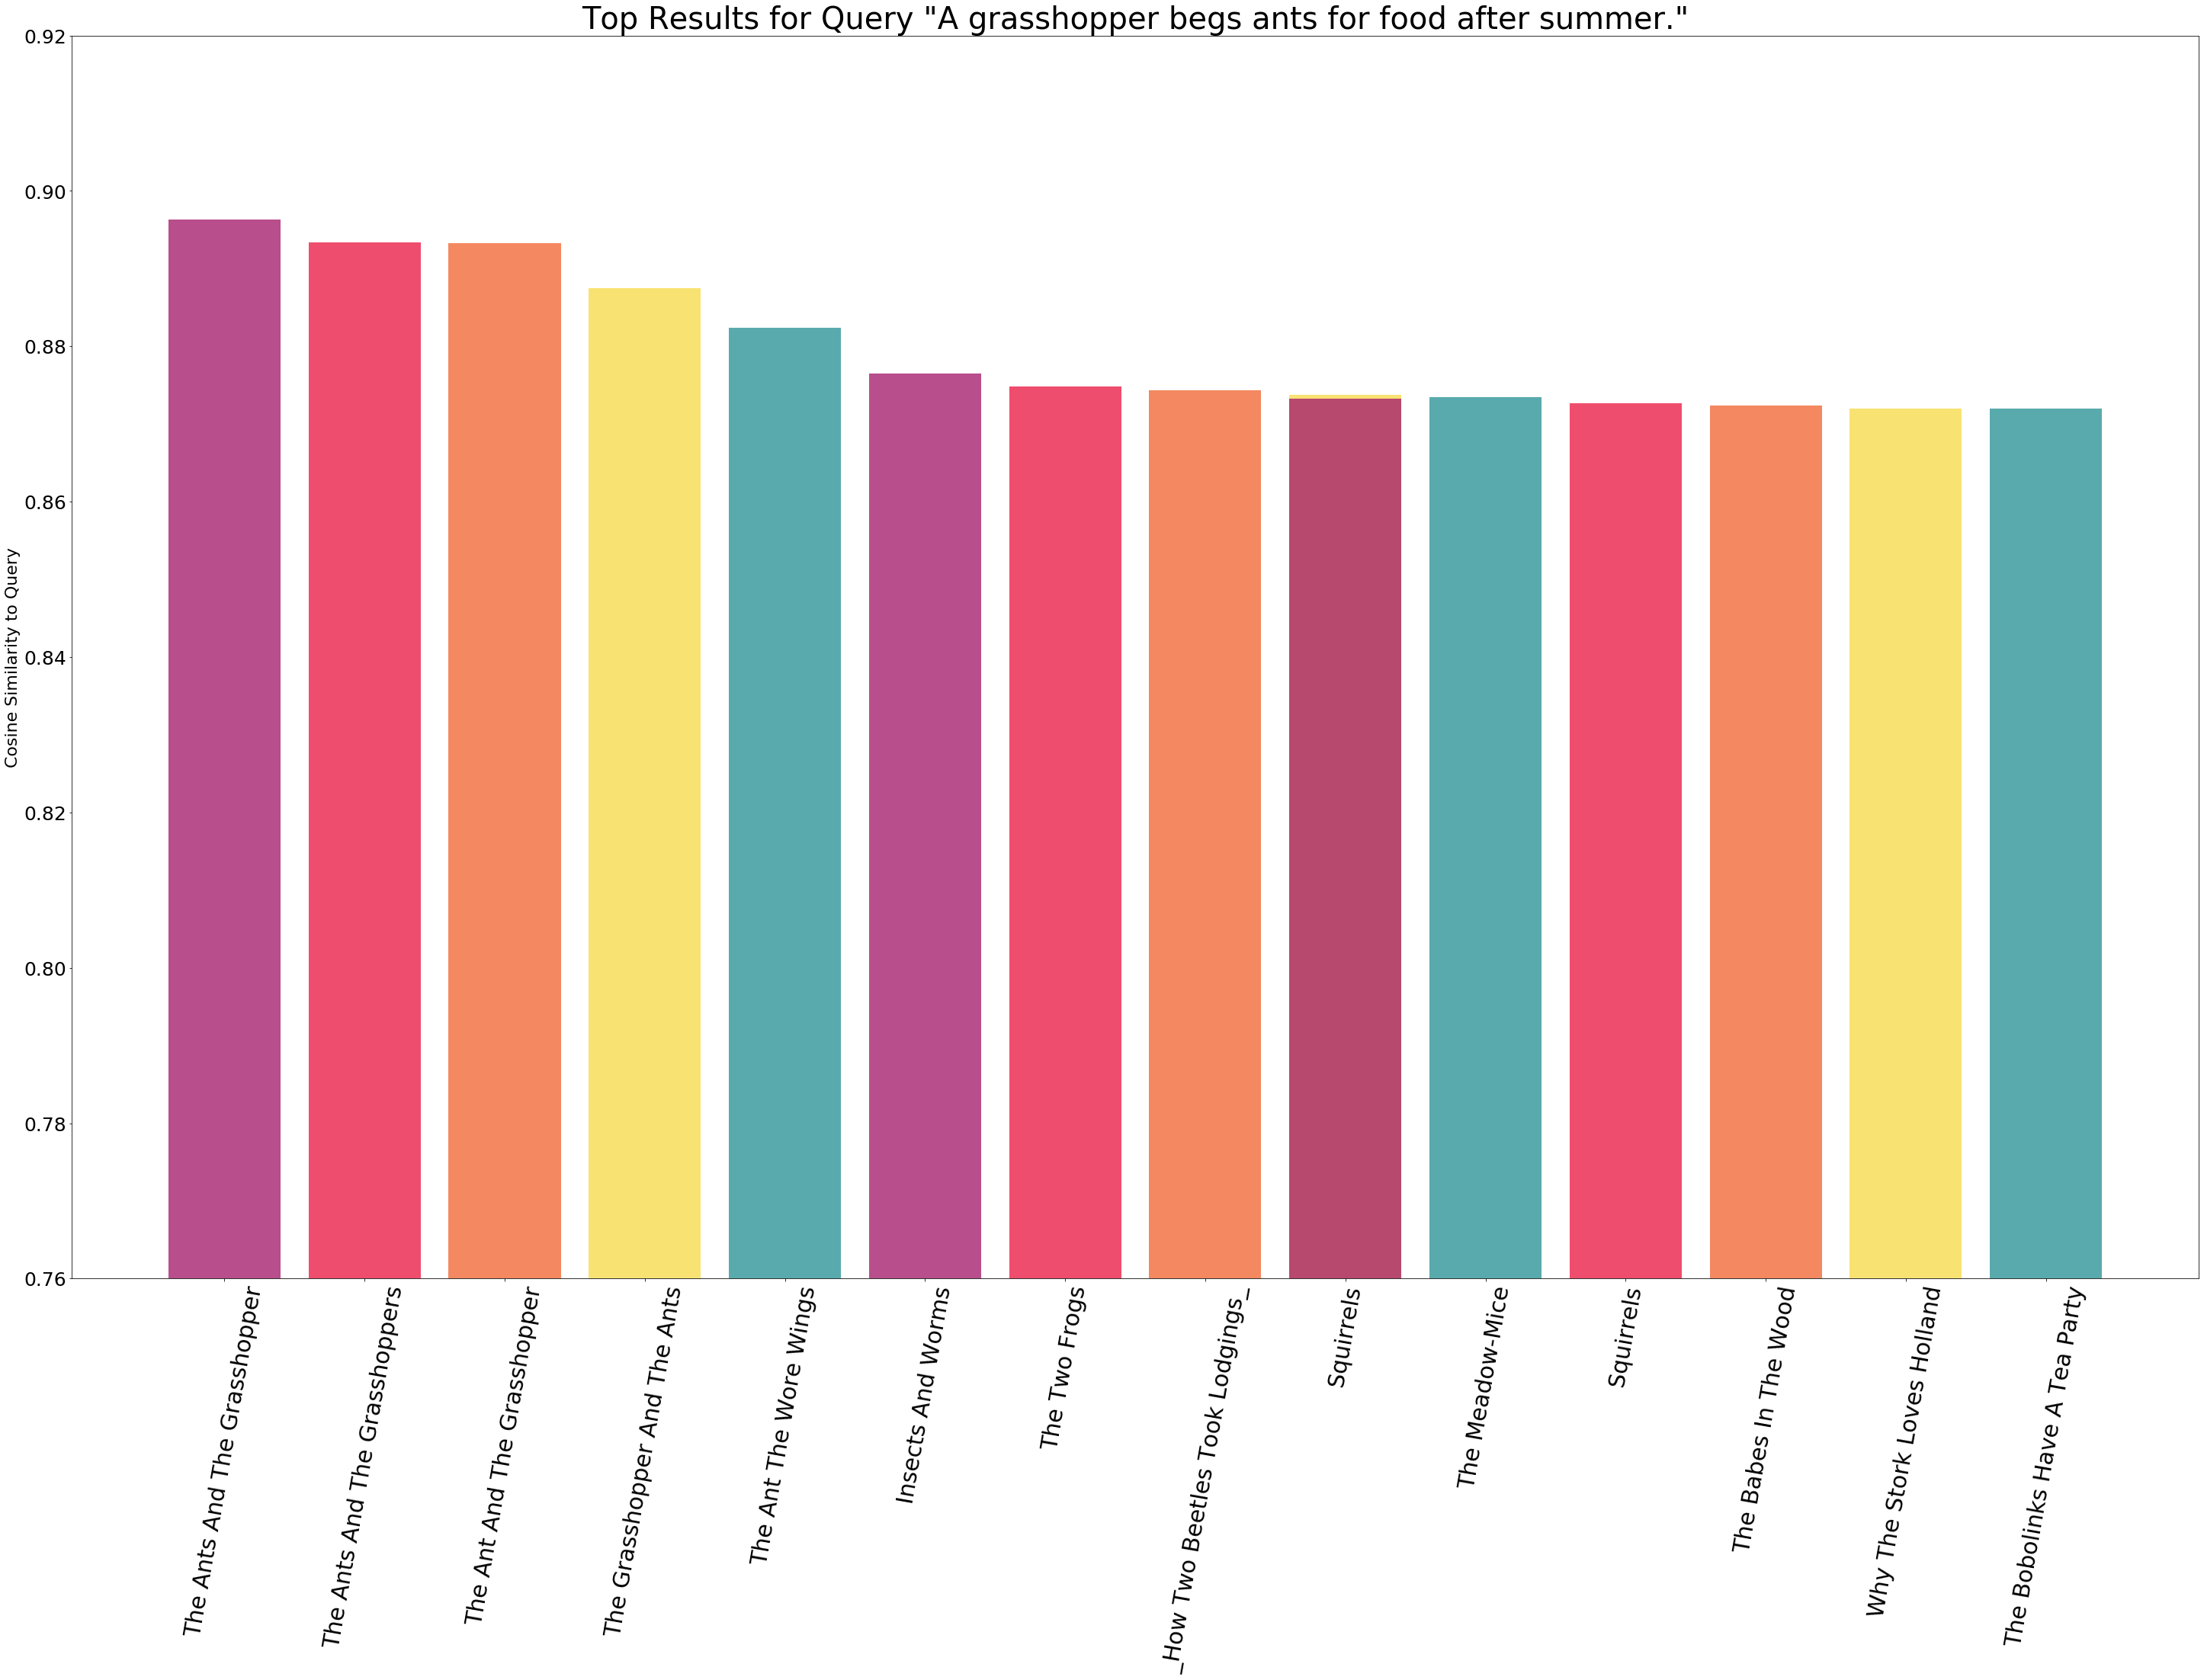

In [110]:
fig, axs=plt.subplots(nrows=1, ncols=1, figsize=[50,30])
axs.bar(indexA, valuesA, alpha=0.8, color=['#A7226E', '#EC2049', '#F26B38', '#F7DB4F', '#2F9599'])
axs.set_ylim([0.76,0.92])
axs.set_ylabel('Cosine Similarity to Query', fontsize=22)
axs.set_xticklabels(indexA, rotation=80,fontsize=30)
plt.yticks(fontsize=25 )
axs.set_title('Top Results for Query "A grasshopper begs ants for food after summer."', fontsize=40)
plt.show()
fig.savefig('grasshopper_query.png')

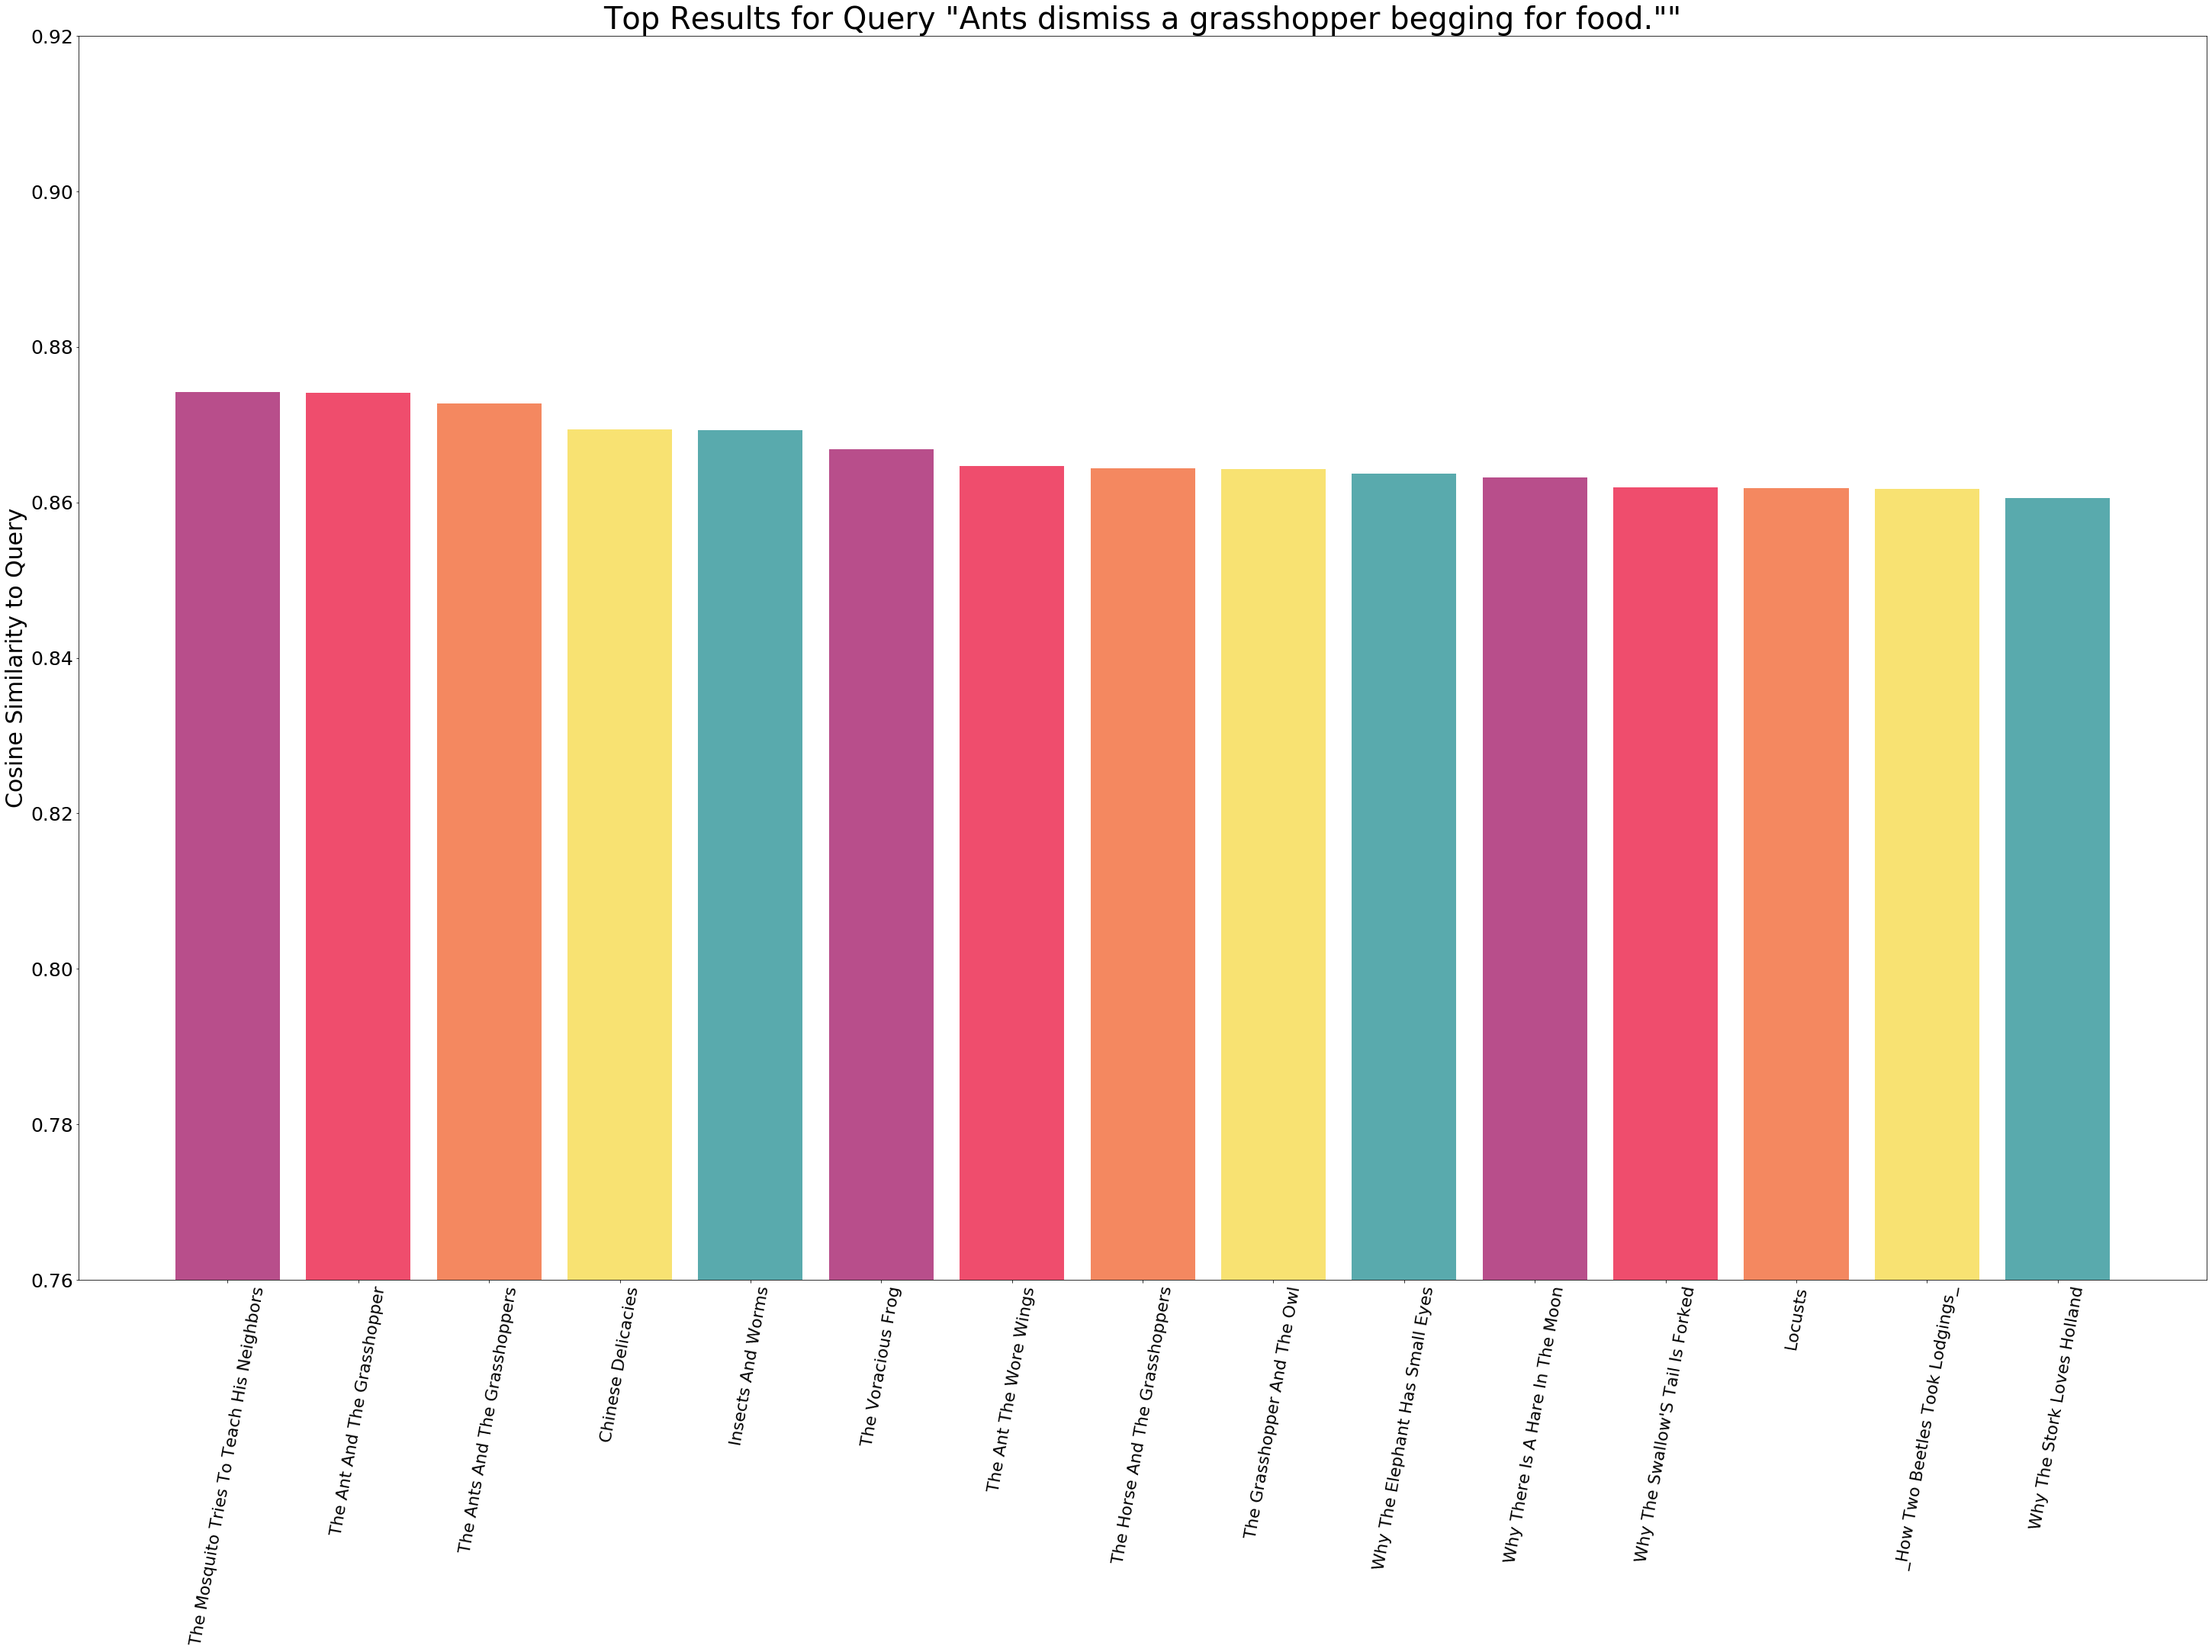

In [109]:
fig, axs=plt.subplots(nrows=1, ncols=1, figsize=[50,30])
axs.bar(indexB, valuesB, alpha=0.8, color=['#A7226E', '#EC2049', '#F26B38', '#F7DB4F', '#2F9599'])
axs.set_ylim([0.76,0.92])
axs.set_ylabel('Cosine Similarity to Query', fontsize=30)
axs.set_xticklabels(indexB, rotation=80,fontsize=22 )
plt.yticks(fontsize=25)
axs.set_title('Top Results for Query "Ants dismiss a grasshopper begging for food.""', fontsize=40)
plt.show()
fig.savefig('antsquery.png')

### Visualizations for query results for 'Aladdin' versus 'aladdin gets three wishes granted by a genie.'

In [71]:
bar_graphC= [(df.loc[x[0], 'story_title'], x[1])for x in query("Aladdin")[:15]]

In [72]:
bar_graphC


[('Bibliography Of Fairy Tales', 0.6091477274894714),
 ('The History Of Ali Baba, And Of The Forty', 0.6018624901771545),
 ("List Of Best Books Of Fairy Tales And Children'S Poems",
  0.5873239636421204),
 ('Fifth Grade', 0.5829311609268188),
 ('Away! Away! To Fairyland', 0.5825258493423462),
 ('Saint Valentine', 0.5812482237815857),
 ('List Of Best Books Of Classic Tales And Old-Fashioned Stories',
  0.5800289511680603),
 ('“Rap! Rap! Rap!”', 0.5798356533050537),
 ('Classics For Children', 0.5738510489463806),
 ("Mr. Stubbs'S Brother", 0.5722767114639282),
 ('Sources Of Story Material For The Rhythmic Period', 0.5667421817779541),
 ('Greek And Roman Myths', 0.5657677054405212),
 ('Midwinter', 0.5656152367591858),
 ('Christmas Everywhere', 0.5632753372192383),
 ('Fairy Adventures', 0.5622010231018066)]

In [77]:
bar_graphD= [(df.loc[x[0], 'story_title'], x[1])for x in query("Aladdin gets three wishes granted by a genie.")[:15]]

In [78]:
bar_graphD

[('James Fenimore Cooper]', 0.8622736930847168),
 ('Briar Rose', 0.8570185303688049),
 ('Aladdin And The Wonderful Lamp', 0.8557236790657043),
 ('And The Wonderful Lamp', 0.8538108468055725),
 ('Aladdin And The Wonderful Lamp', 0.8532981276512146),
 ('Aladdin And The Wonderful Lamp', 0.8531286120414734),
 ('Aladdin And The Magic Lamp', 0.852628231048584),
 ('Aladdin And The Wonderful Lamp', 0.8519588708877563),
 ('Aladdin, Or The Magic Lamp', 0.8477104902267456),
 ('Adapted From The Brothers Grimm', 0.8475358486175537),
 ('Cinderella', 0.847214937210083),
 ('The Puppet-Show Man', 0.8465716242790222),
 ('My Girls', 0.8465399742126465),
 ('Rufus Bondifeller', 0.8462048172950745),
 ("The King'S Foot Holder", 0.8447015285491943)]

In [79]:
indexC= [title for title, value in bar_graphC]
valuesC= [value for title, value in bar_graphC]

indexD= [title for title, value in bar_graphD]
valuesD= [value for title, value in bar_graphD]

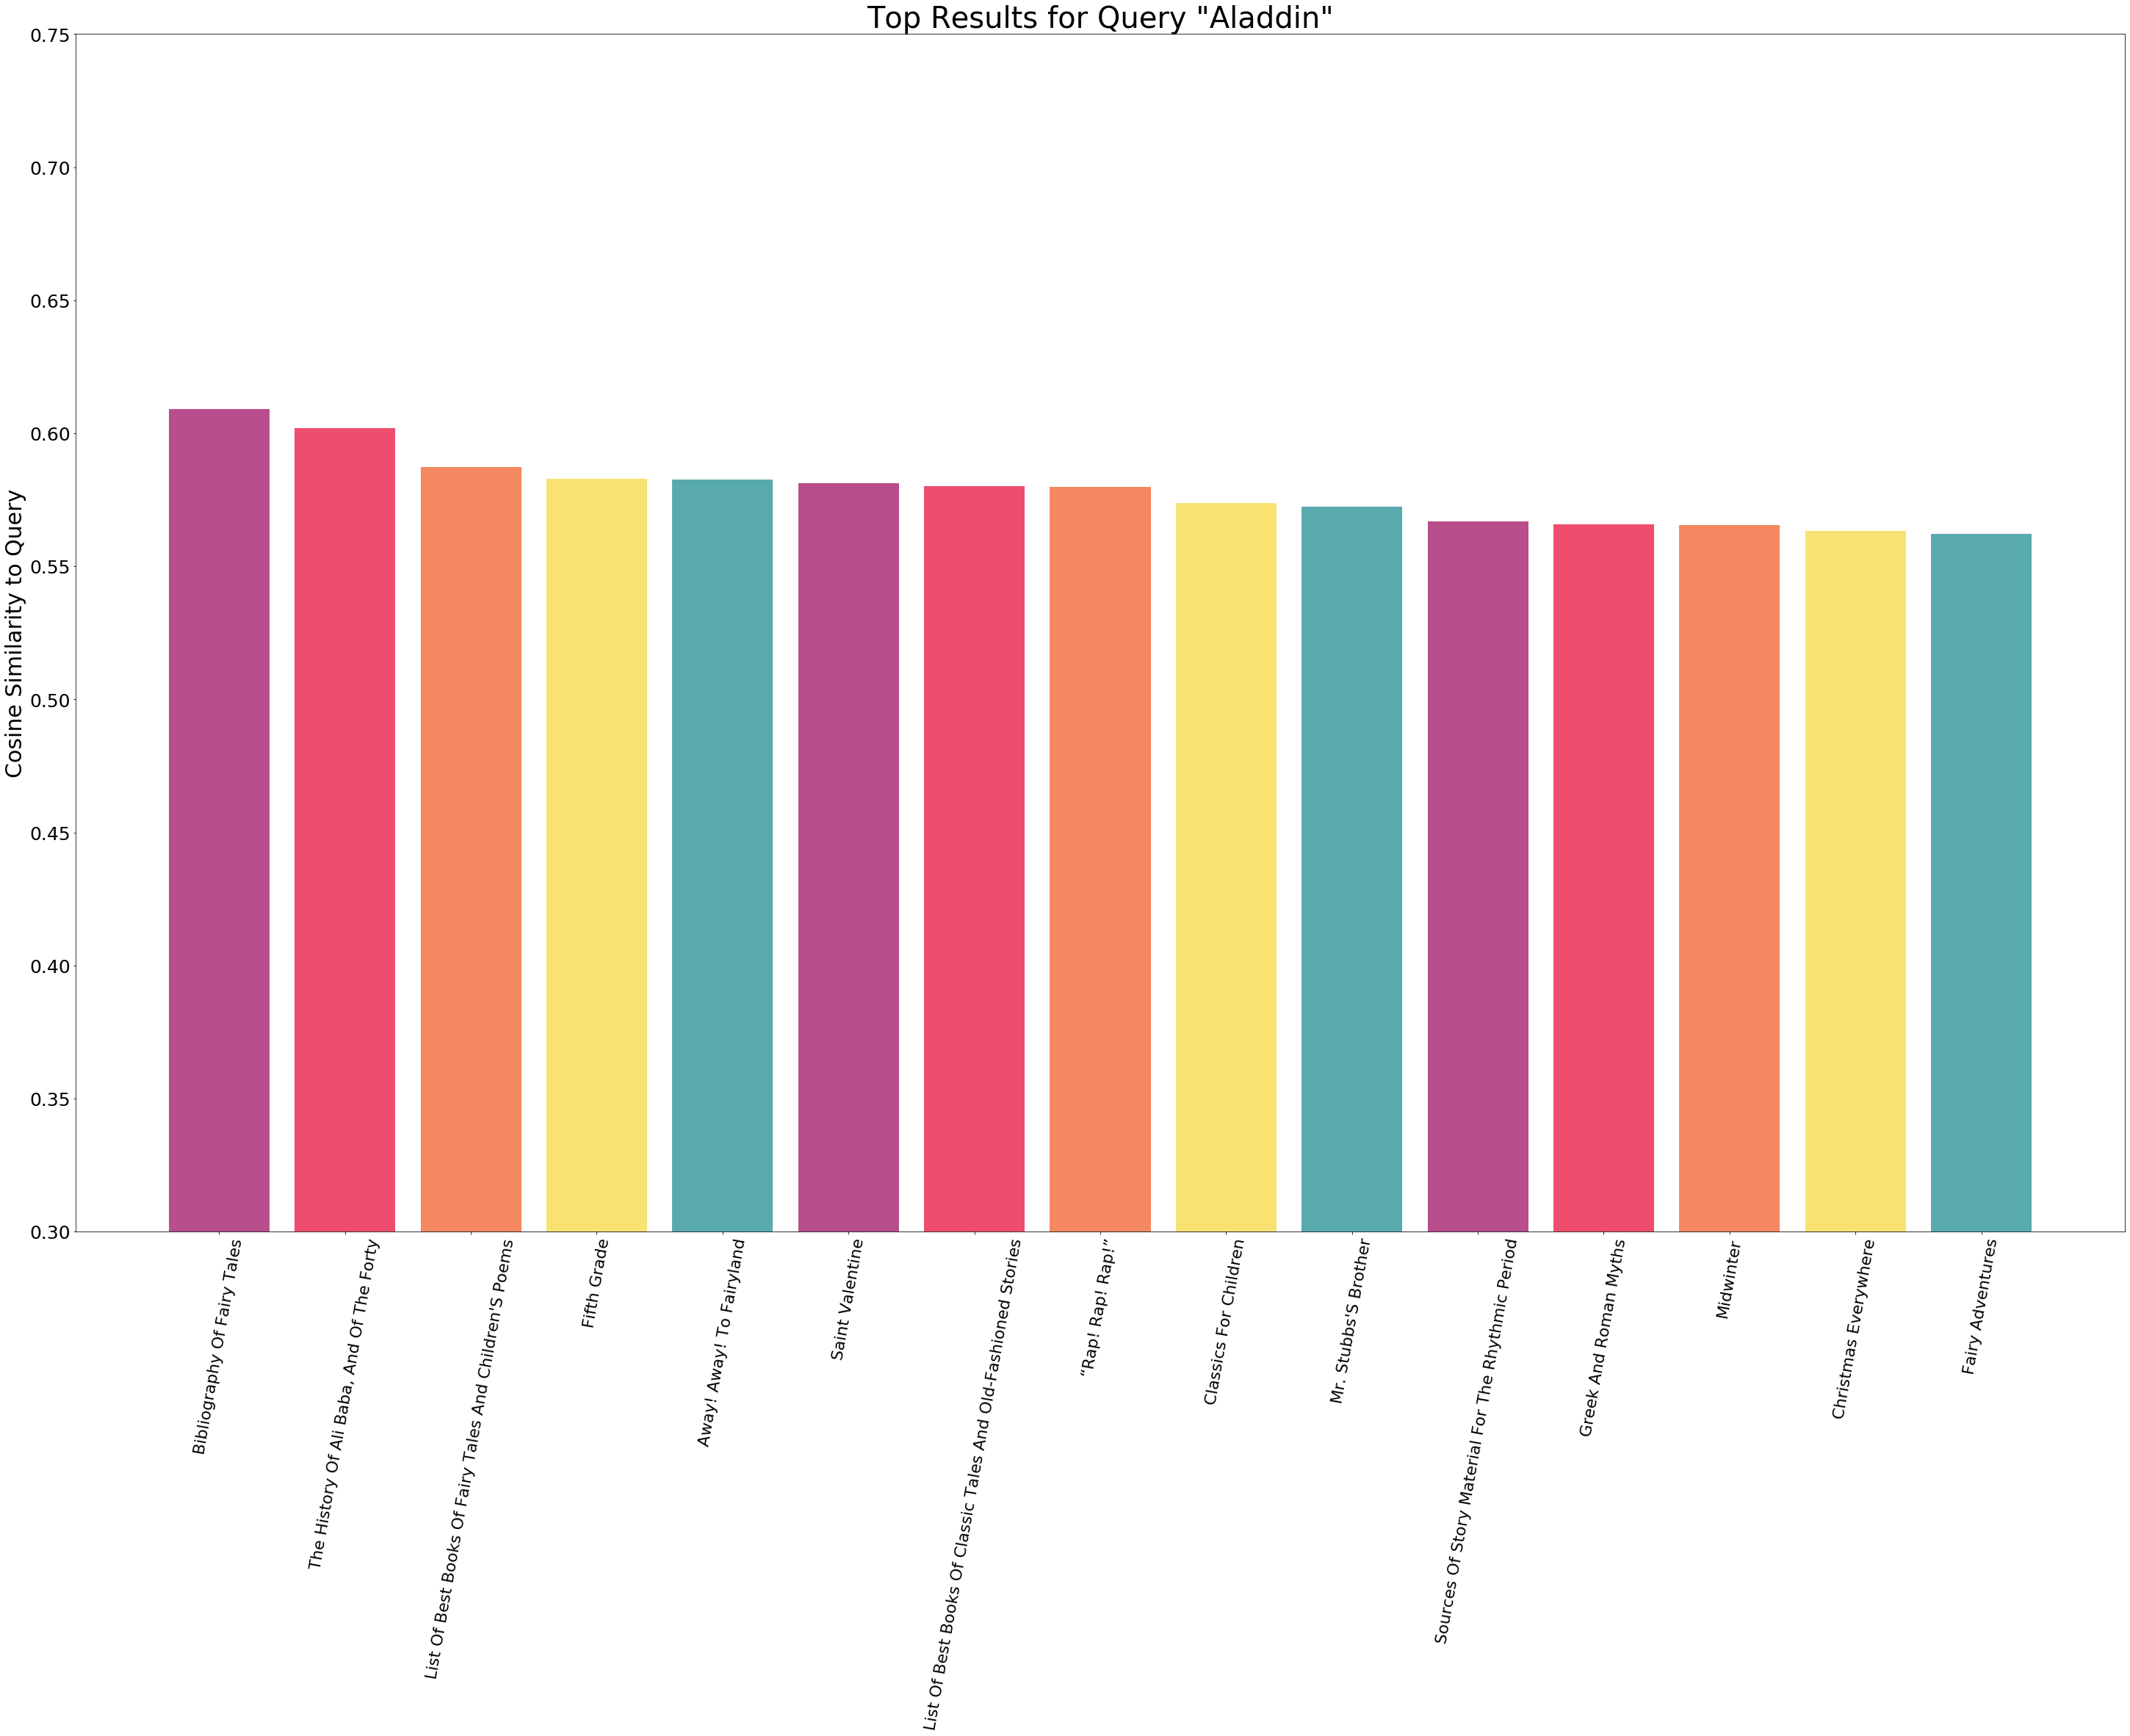

In [108]:
fig, axs=plt.subplots(nrows=1, ncols=1, figsize=[50,30])
axs.bar(indexC, valuesC, alpha=0.8, color=['#A7226E', '#EC2049', '#F26B38', '#F7DB4F', '#2F9599'])
axs.set_ylim([0.3,0.75])
axs.set_ylabel('Cosine Similarity to Query', fontsize=30)
axs.set_xticklabels(indexC, rotation=80,fontsize=22)
plt.yticks(fontsize=25)
axs.set_title('Top Results for Query "Aladdin"', fontsize=40)
plt.show()
fig.savefig('aladdinquery.png')

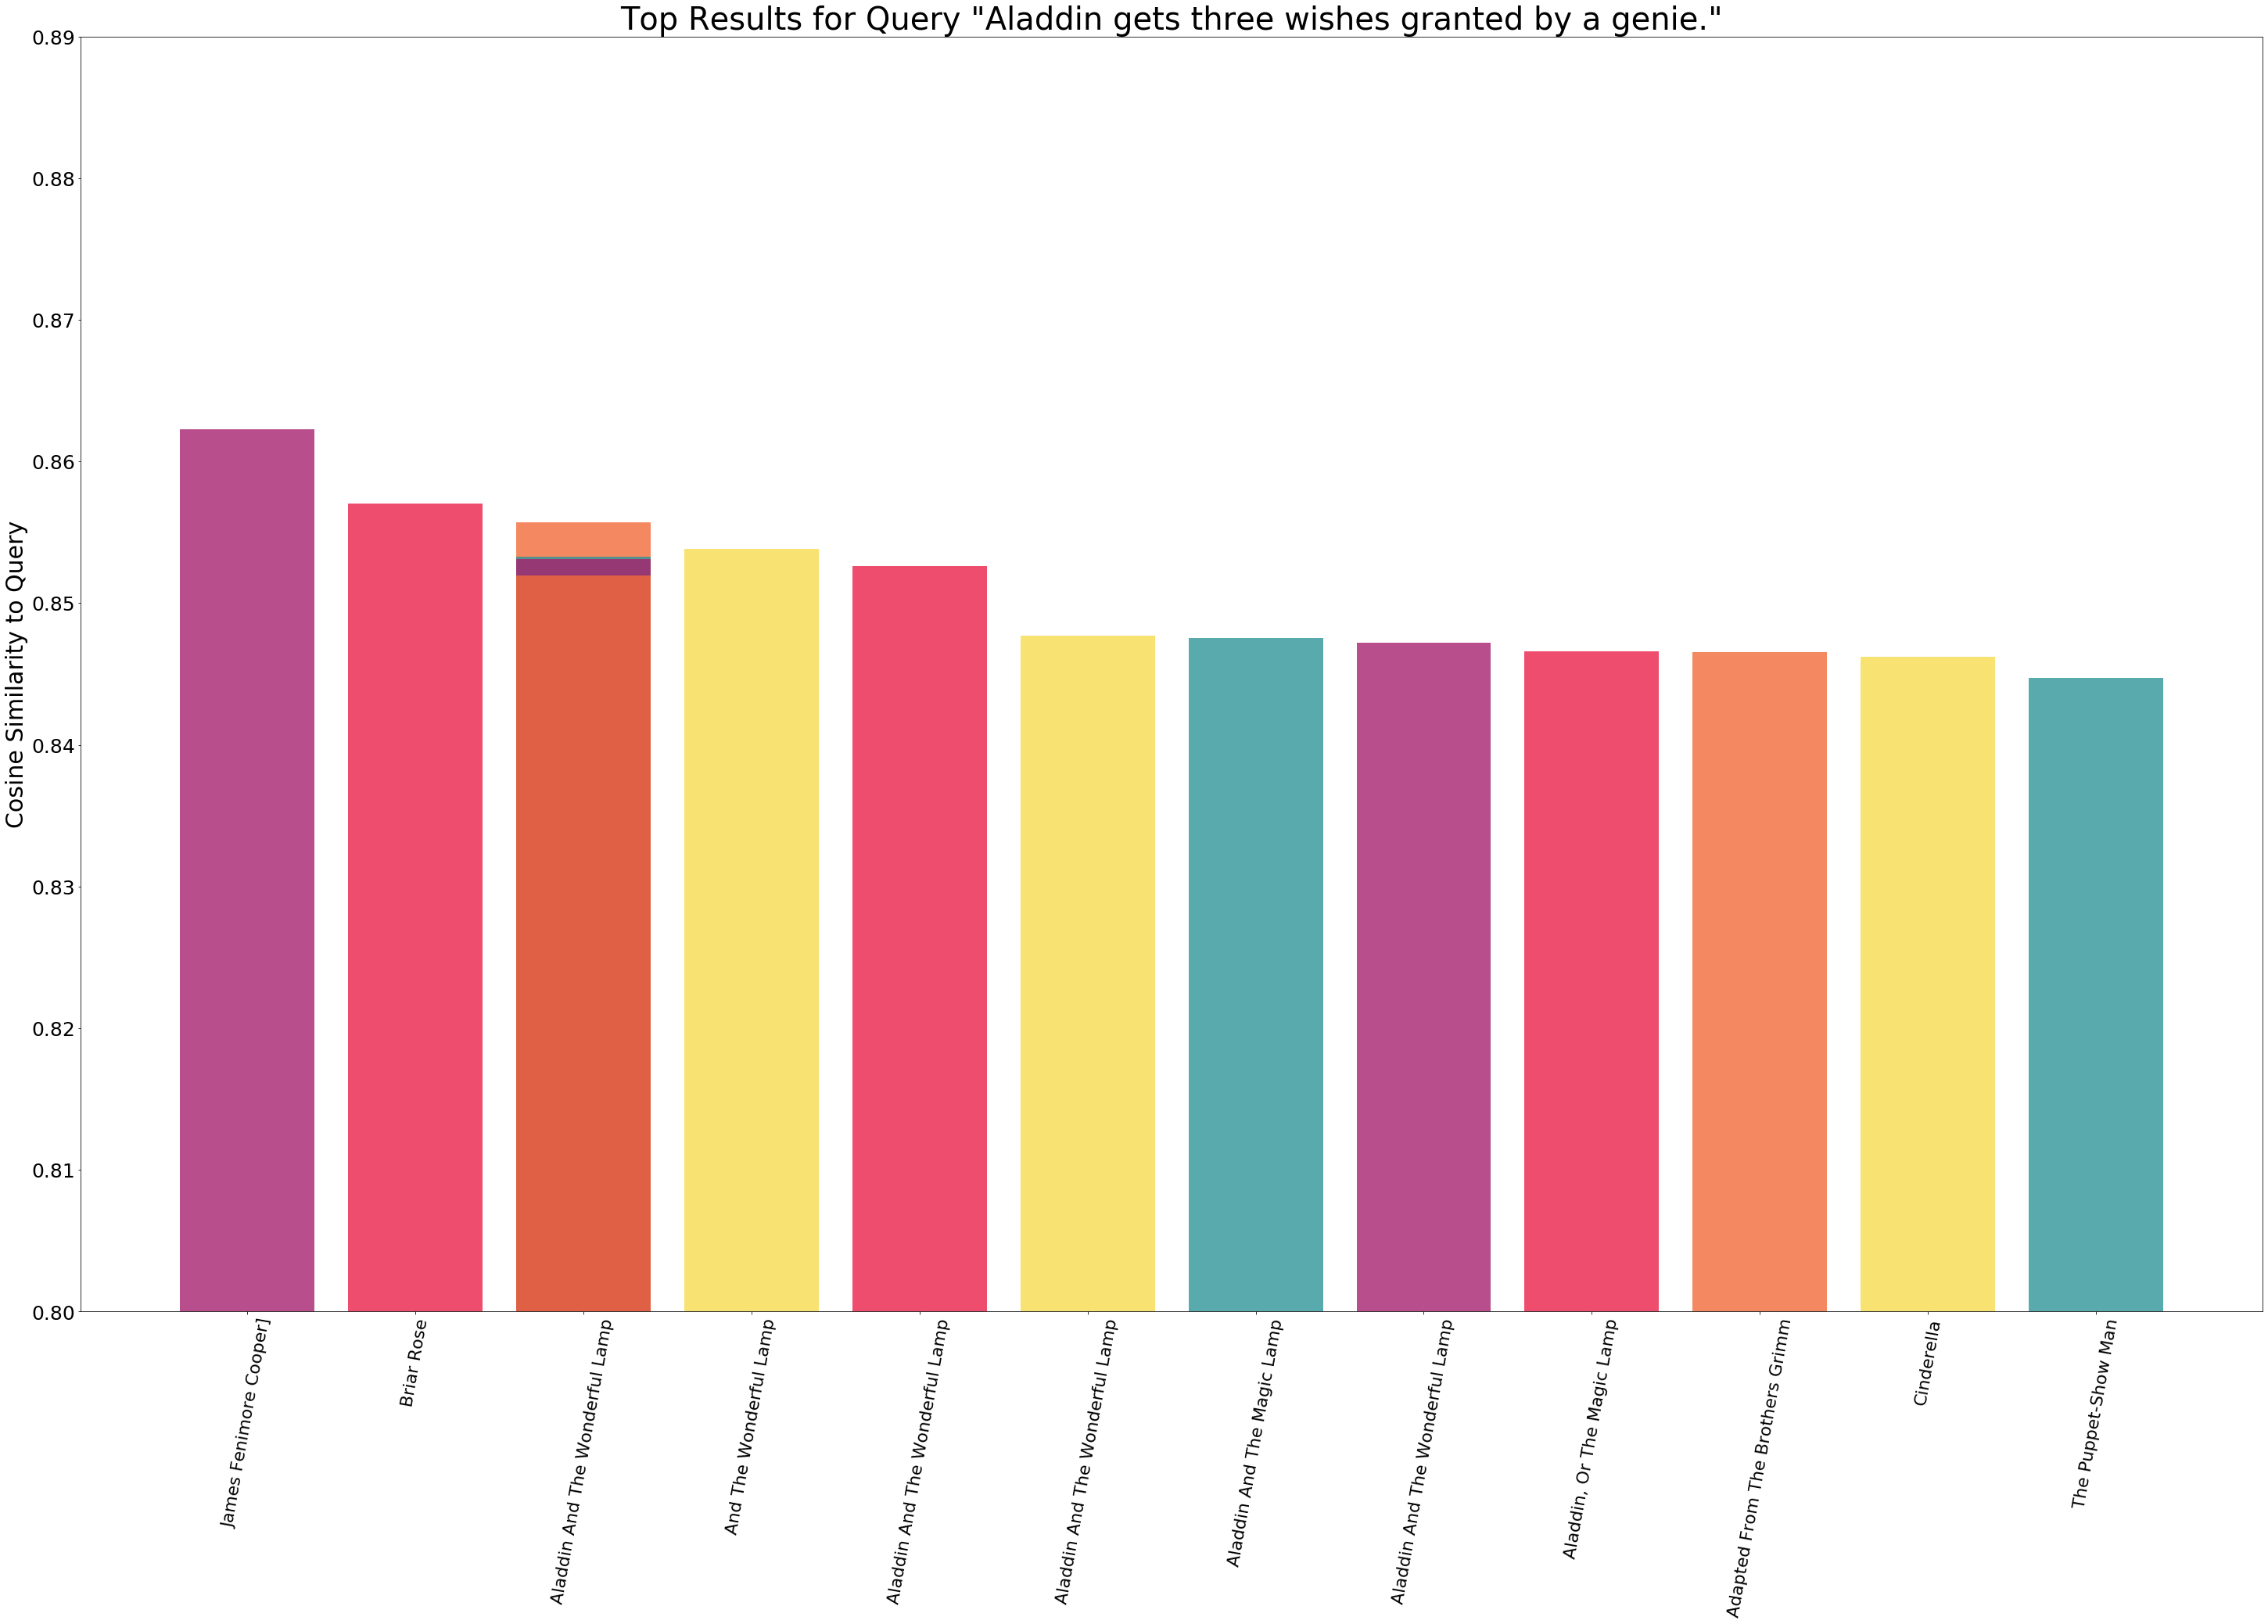

In [107]:
fig, axs=plt.subplots(nrows=1, ncols=1, figsize=[50,30])
axs.bar(indexD, valuesD, alpha=0.8, color=['#A7226E', '#EC2049', '#F26B38', '#F7DB4F', '#2F9599'])
axs.set_ylim([0.8,0.89])
axs.set_ylabel('Cosine Similarity to Query', fontsize=30)
axs.set_xticklabels(indexD, rotation=80,fontsize=22 )
plt.yticks(fontsize=25)
axs.set_title('Top Results for Query "Aladdin gets three wishes granted by a genie."', fontsize=40)
plt.show()
fig.savefig('aladdinsummaryquery.png')

In [263]:
bar_graphC= [(df.loc[x[0], 'story_title'], x[1])for x in query("Aladdin")[:15]]

In [264]:
bar_graphC

[('Bibliography Of Fairy Tales', 0.6091477274894714),
 ('The History Of Ali Baba, And Of The Forty', 0.6018624901771545),
 ("List Of Best Books Of Fairy Tales And Children'S Poems",
  0.5873239636421204),
 ('Fifth Grade', 0.5829311609268188),
 ('Away! Away! To Fairyland', 0.5825258493423462),
 ('Saint Valentine', 0.5812482237815857),
 ('List Of Best Books Of Classic Tales And Old-Fashioned Stories',
  0.5800289511680603),
 ('“Rap! Rap! Rap!”', 0.5798356533050537),
 ('Classics For Children', 0.5738510489463806),
 ("Mr. Stubbs'S Brother", 0.5722767114639282),
 ('Sources Of Story Material For The Rhythmic Period', 0.5667421817779541),
 ('Greek And Roman Myths', 0.5657677054405212),
 ('Midwinter', 0.5656152367591858),
 ('Christmas Everywhere', 0.5632753372192383),
 ('Fairy Adventures', 0.5622010231018066)]

In [84]:
bar_graphD= [(df.loc[x[0], 'story_title'], x[1])for x in query("aladdin gets three wishes granted by a genie.")[:15]]

In [98]:
query("aladdin gets three wishes granted by a genie.")[0]

(9716, 0.8622736930847168)

In [94]:
#I was confused why this was the top result in the summary query, turns out it was a plot summary form Cinderella!
df.loc[9716, 'story_text']

'A. The Plot The main line of events leading up to the climax of interest in the story may be called the plot. It is the plot that furnishes excitement, and for perhaps the majority of readers constitutes the chief interest. In some stories the plot lies upon the surface all the time, and everything is made subservient to the purpose of holding interest, keeping up excitement and mystifying the reader until the climax is reached. Thrilling detective stories of the poorer class, exciting love stories and the cheap juvenile tales of Indian fighting, with heroines in dire distress and heroes struggling to rescue them, are illustrations of this type. No effort is made by the author to make real human beings of his characters, and little or no profit comes to the reader, while infinite harm may be done to minds craving excitement and finding in it nothing to stimulate an interest in better things. In the better stories of greater writers the plot still plays an important part, but while it 

### 3d Visualizations

I thought it would be useful to highlight the recommendations made by spaCy on a t-SNE graph of the vectors. However, the results were disappointing. I want to revise this later.

Visualization code found here:
1. https://towardsdatascience.com/creating-a-brewery-recommender-with-doc2vec-15ca20e28e7a
2. https://stackoverflow.com/questions/18344934/animate-a-rotating-3d-graph-in-matplotlib/52360809
3. https://pythonmatplotlibtips.blogspot.com/2018/11/3d-scatter-plot-animation-funcanimation-python-matplotlib.html

In [274]:
from sklearn.manifold import TSNE


In [285]:

from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

In [275]:
vectors.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
            ...
            21453, 21454, 21455, 21456, 21457, 21458, 21459, 21460, 21461, 21462], dtype='int64', length=21463)

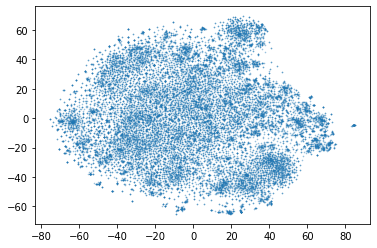

In [277]:

doc_tags = list(vectors.index)
X = list(vectors)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)


In [ ]:

plt.scatter(visual_df['x'], visual_df['y'], y s=0.4, alpha=0.4)

In [278]:
doc_tags = list(vectors.index)
Z = list(vectors)
tsnez = TSNE(n_components=3, n_jobs=-1)
Z_tsne = tsnez.fit_transform(X)


In [280]:
visual_df_z = pd.DataFrame(Z_tsne, index=doc_tags, columns=['x', 'y','z'])

In [ ]:
# Create a figure and a 3D Axes
fig = plt.figure(figsize=[60,60])
ax = Axes3D(fig)


def init():
    ax.scatter(visual_df_z.x, visual_df_z.y, visual_df_z.z, marker='o', s=20, c="goldenrod", alpha=0.6)
    return fig,

def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
fig.legend

In [ ]:

anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])